Tutorial from [towardsdatascience](https://towardsdatascience.com/building-a-convolutional-neural-network-cnn-in-keras-329fbbadc5f5)

# Explore the data

2023-02-10 17:43:09.069127: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-10 17:43:10.219840: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-02-10 17:43:10.219964: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-02-10 17:43:10.219978: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like t

array([[<matplotlib.image.AxesImage object at 0x7fab1d979f10>, 5],
       [<matplotlib.image.AxesImage object at 0x7fab1d91c100>, 0],
       [<matplotlib.image.AxesImage object at 0x7fab1d91c430>, 4],
       [<matplotlib.image.AxesImage object at 0x7fab1d91c760>, 1],
       [<matplotlib.image.AxesImage object at 0x7fab1d91ca90>, 9]],
      dtype=object)

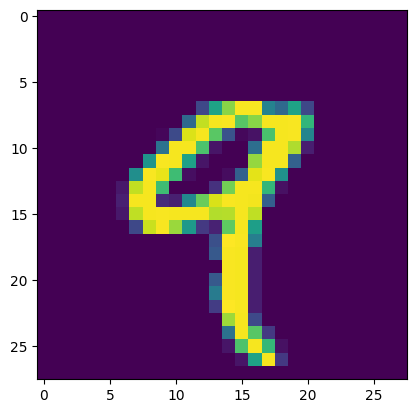

In [4]:

# load the dataset 
import keras
from keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np

#download mnist data and split into train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

rows = [
    [
        plt.imshow(X_train[x]),
        y_train[x]
    ] 
    for x in range(5) ]

np.array(rows)

# One hot encode the catagorical data

The `y` columns for `train` and `test` are integer values that represent a number (0 through to 9).

Many machine learning algorithms cannot operate on label data directly and therefore all input/outputs need to be numeric. Usually a constraint of efficient algorithms over alforithms themselves.

Catagorical data must therefore be translated to numerical data by integer encoding or one-hot encoding

## One hot encoding 

One hot encoding expands a single column that represents catagorical data into multiple columns; one for each distinct label in the category. The columns are then assigned a binary 0 or 1 depending on the the value of the label. 

[See more](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/)

(0, array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32))

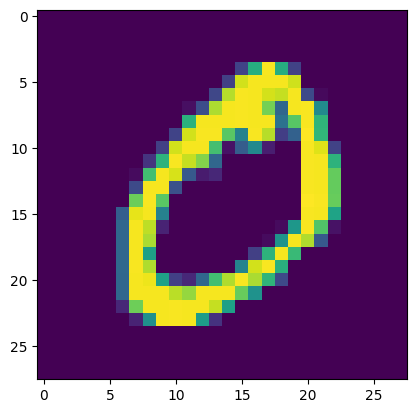

In [5]:
from keras.utils import to_categorical#one-hot encode target column

ohe_y_train = to_categorical(y_train)
ohe_y_test = to_categorical(y_test)

index = 1
plt.imshow(X_train[index]),
(y_train[index],
ohe_y_train[index])

# Model

In [6]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten#create model
import datetime
import tensorflow as tf

model = Sequential()#add model layers
model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(28,28,1)))
model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model.fit(
    X_train,
    ohe_y_train,
    validation_data=(X_test, ohe_y_test),
    epochs=1,
    callbacks=[tensorboard_callback]
)

2023-02-10 17:43:12.656487: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-02-10 17:43:12.656581: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (vscode-gpus-instance): /proc/driver/nvidia/version does not exist
2023-02-10 17:43:12.657457: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


1875/1875 [==============================] - 104s 55ms/step - loss: 0.2244 - accuracy: 0.9520 - val_loss: 0.0815 - val_accuracy: 0.9755


# Serving the model

First, we have to save the model. The first function creates a protobuf format that is compatible with Tensorflow serving.

The next step builds the Docker container that houses the model.

required directory structure: 
/model/{modelname}/${versionnumber}


In [7]:
!rm -rf output
from keras.models import save_model
import os

version = 1
save_model(
    model,
    os.path.abspath(os.getcwd())+"/output/1",
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None,
)

INFO:tensorflow:Assets written to: /home/vscode/src/predict-handwritten-numbers/output/1/assets


INFO:tensorflow:Assets written to: /home/vscode/src/predict-handwritten-numbers/output/1/assets


In [3]:
! docker build -t docker.io/kieranbamforth/predict-handwritten-numbers .

Emulate Docker CLI using podman. Create /etc/containers/nodocker to quiet msg.
STEP 1/3: FROM docker.io/tensorflow/serving:2.11.0
STEP 2/3: WORKDIR /models/model
--> Using cache 08386ae5068577bc69f8e584a258cbdfaa692f3821425bd0b332627494373d61
--> 08386ae5068
STEP 3/3: COPY ./output ./
--> Using cache d6e10f2b1afa45bc34cb78d8653768f45774424ec239cfc37603d285454b2d01
COMMIT docker.io/kieranbamforth/predict-handwritten-numbers
--> d6e10f2b1af
Successfully tagged docker.io/kieranbamforth/predict-handwritten-numbers:latest
Successfully tagged docker.io/kieran-ohara/predict-handwritten-numbers:latest
Successfully tagged localhost/kieran-ohara/predict-handwritten-numbers:latest
d6e10f2b1afa45bc34cb78d8653768f45774424ec239cfc37603d285454b2d01


# Using/infering the saved model

We can explore the inputs and outputs of a saved model by using the `saved_model_cli`.

See https://yu-ishikawa.medium.com/how-to-show-signatures-of-tensorflow-saved-model-5ac56cf1960f

In [3]:
! saved_model_cli show --dir output/1 --all

2023-02-11 15:20:27.365961: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-11 15:20:28.489027: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-02-11 15:20:28.489143: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-02-11 15:20:28.489166: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like t